In [1]:
# Main 

import torch
import numpy as np 
from tqdm import tqdm

torch.manual_seed(3) 

n = 1

class MeanField(torch.nn.Module):
    
    def __init__(self, q, w, sig, h, lam):
        super().__init__()  
        
        # Initial guess for mean and variance of neuronal input 
        ts_init = 0.31 # mean neuronal input
        ssq_init = 2.36 # variance of neuronal input

        self.t = torch.nn.Parameter(torch.tensor(ts_init/np.sqrt(ssq_init))) # mean/std of neuronal input
        self.s = torch.nn.Parameter(torch.tensor(np.sqrt(ssq_init))) # std of neuronal input 
        
        # Model parameters
        self.q = q # proportion 
        self.w = w # mean synaptic weight 
        self.sig = sig # variance of synaptic weight
        self.h = h # mean input 
        self.lam = lam # variance of input 

    def forward(self):

        # Mean neuronal input 
        ts_true = self.t * self.s 

        transfer1 = 0.5 * (self.t**2 + 1) * (torch.erf(self.t / torch.sqrt(torch.tensor(2.0))) + 1) 
        transfer1 += 1 / (torch.sqrt(2 * torch.tensor(np.pi))) * self.t * torch.exp(-self.t**2 / 2) 
        # transfer1 = self.t**2 # approximate version 
        ts_rate = self.h + self.w * self.q * (self.s)**2 * transfer1

        # Variance of neuronal input 
        ssq_true = self.s**2

        transfer2 = 0.5 * (self.t**4 + 6*self.t**2 + 3) * (torch.erf(self.t / torch.sqrt(torch.tensor(2.0))) + 1) 
        transfer2 += 1 / (torch.sqrt(2 * torch.tensor(np.pi))) * self.t * (self.t**2 + 5) * torch.exp(-self.t**2 / 2)
        # transfer2 = self.t**4 + 6*self.t**2 # approximate version 
        # transfer2 = self.t**4 # approximate version
        ssq_rate = self.lam + self.sig**2 * self.q * (self.s)**4 * transfer2

        return ts_true, ts_rate, ssq_true, ssq_rate

num_w = 5
num_h = 5
loss_arr = np.zeros(shape=(num_w, num_h))

for i, w_val in enumerate(np.linspace(0, 2, num_w)) : 
    
    for j, h_val in enumerate(np.linspace(0, 2,num_h)) : 
        
        # Instantiate model parameter
        q = torch.FloatTensor(np.ones(shape=(n,)))
        w = -torch.FloatTensor(np.ones(shape=(n,n))) * w_val
        sig = torch.FloatTensor(np.ones(shape=(n,n)))
        h = torch.FloatTensor(np.ones(shape=(n,))) * h_val
        lam = torch.FloatTensor(np.ones(shape=(n,)))

        # Instantiate model 
        mf = MeanField(q, w, sig, h, lam)

        # print(mf.t)
        # print(mf.s)
        # print(list(mf.parameters()))
 
        optimizer = torch.optim.Adam(mf.parameters())

        # Report these variables every iteration
        loss_list = [] 
        ts_list = [] 
        ssq_list = [] 
        t_list = []
        s_list = []
        at_list = []
        as_list = []    

        for epoch in tqdm(range(10000)):

            optimizer.zero_grad()
            
            # Calculate LHS and RHS of mean field equations
            ts_true, ts_rate, ssq_true, ssq_rate = mf()

            # Calculate Loss 
            ts_err = ts_rate - ts_true # error in self-consistency of mean input
            ssq_err = ssq_rate - ssq_true # error in self-consistency of variance of input 
            loss = torch.sum(ts_err**2) + torch.sum(ssq_err**2)
            
            # Gradient descent 
            loss.backward()
            optimizer.step()
            
            # Ensure positive support 
            mf.s.data = mf.s.clamp(min=0.)
            mf.t.data = mf.t.clamp(min=0.)

            # Report variables 
            loss_list.append(loss.detach())
            ts_list.append(ts_true.detach())
            ssq_list.append(ssq_true.detach())
            t_list.append(mf.t.detach())
            s_list.append(mf.s.detach())
            at_list.append(mf.t.grad.data)
            as_list.append(mf.s.grad.data)

        loss_arr[i,j] = loss_list[-1]

100%|██████████| 10000/10000 [00:11<00:00, 900.24it/s]


Junk

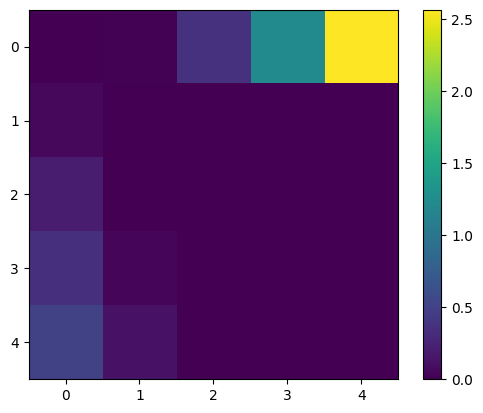

In [2]:
import matplotlib.pyplot as plt 

# Plot the array as a colormap
plt.imshow(loss_arr, cmap='viridis')
plt.colorbar()  # Add a color bar to show the scale
plt.show()

In [3]:
print(loss_arr) 

[[0.00000000e+00 1.22696375e-02 3.65947753e-01 1.21731913e+00
  2.56800008e+00]
 [5.88235296e-02 0.00000000e+00 1.38165035e-11 3.43607987e-08
  5.81836535e-09]
 [2.00000003e-01 0.00000000e+00 2.22044605e-16 4.04498657e-10
  4.10782519e-12]
 [3.60000014e-01 3.99999917e-02 0.00000000e+00 1.77635684e-14
  9.84101689e-13]
 [5.00000000e-01 1.25000000e-01 0.00000000e+00 2.22044605e-16
  3.55271368e-15]]


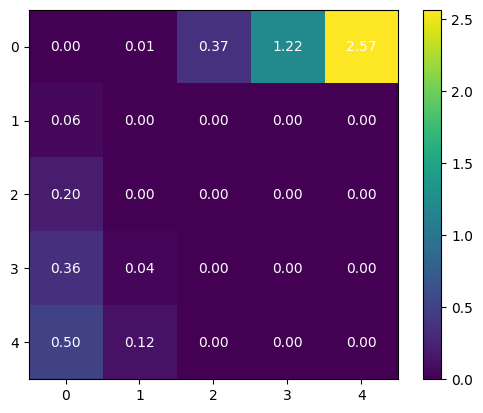

In [5]:
data = loss_arr
# Plot the array as a colormap with numeric values
plt.imshow(data, cmap='viridis')

# Add text annotations for each cell
for i in range(len(data)):
    for j in range(len(data[i])):
        plt.text(j, i, "{:.2f}".format(data[i, j]), ha='center', va='center', color='white')

plt.colorbar()  # Add a color bar to show the scale
plt.show()

Text(0, 0.5, 'Loss')

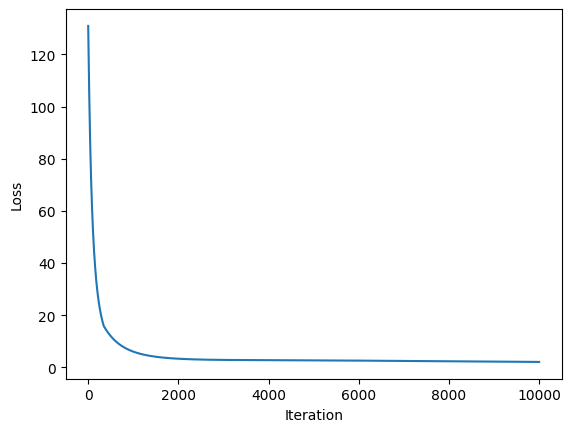

In [225]:
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.ylim(0,1)

In [216]:
print(mf.t)
print(mf.s)
print(loss_list[-1])

Parameter containing:
tensor(0., dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(0.8660, dtype=torch.float64, requires_grad=True)
tensor(0.1250)


tensor(0., dtype=torch.float64)


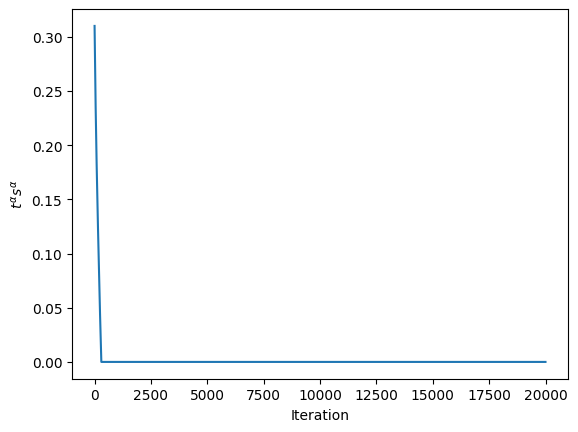

In [217]:
plt.plot(ts_list)
plt.xlabel('Iteration')
plt.ylabel(r'$t^\alpha s^\alpha$')
print(ts_list[-1])

tensor(0.7500, dtype=torch.float64)


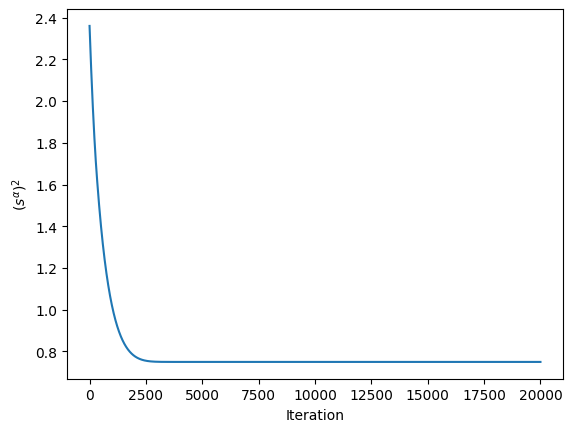

In [218]:
plt.plot(ssq_list)
plt.xlabel('Iteration')
plt.ylabel(r'$(s^\alpha)^2$')
print(ssq_list[-1])

Text(0, 0.5, '$t^\\alpha$')

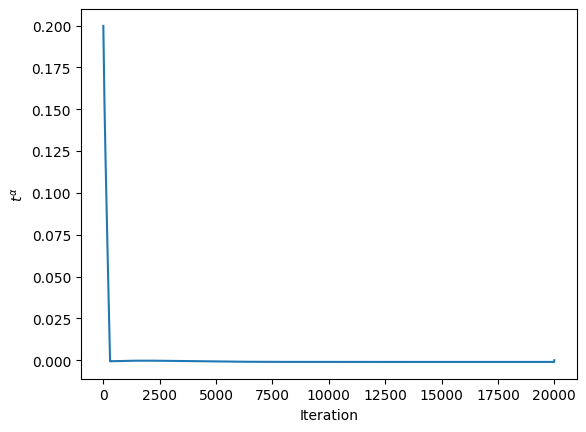

In [219]:
plt.plot(t_list)
plt.xlabel('Iteration')
plt.ylabel(r'$t^\alpha$')
# plt.ylim(5.5,6.5)

Text(0, 0.5, 'Gradient $t^\\alpha$')

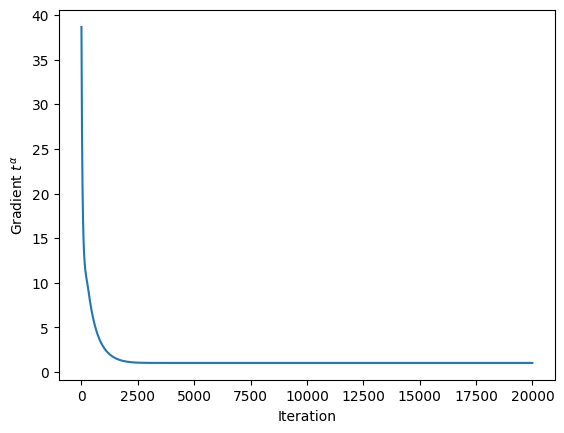

In [220]:
plt.plot(at_list)
# plt.plot(as_list)

plt.xlabel('Iteration')
plt.ylabel(r'Gradient $t^\alpha$')
#plt.ylim(-1,1)

Text(0, 0.5, '$s^\\alpha$')

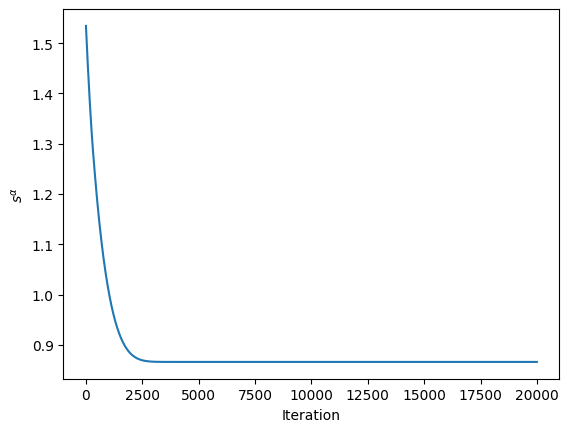

In [221]:
plt.plot(s_list)
plt.xlabel('Iteration')
plt.ylabel(r'$s^\alpha$')

tensor([0.0036])


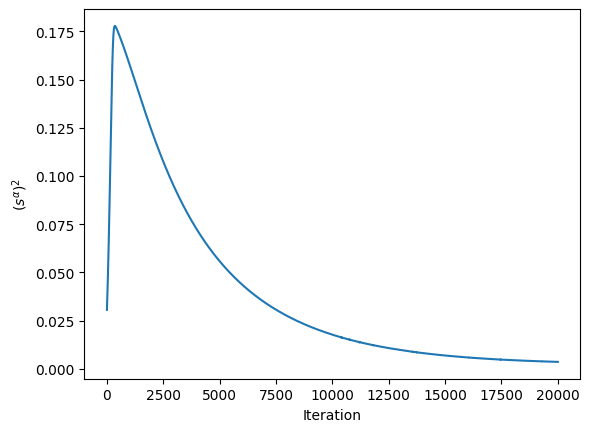

In [29]:
from sympy import Symbol

In [30]:
from sympy.solvers import solve 

In [33]:
x = Symbol('x')

In [34]:
solve(x**2  - 1, x)

[-1, 1]

In [38]:
from sympy import Symbol, nsolve
import mpmath
mpmath.mp.dps = 10
x1 = Symbol('x1')
x2 = Symbol('x2')

f1 = 3 * x1**2 - 2 * x2**2 - 1
f2 = x1**2 - 2 * x1 + x2**2 + 2 * x2 - 8
print(nsolve((f1, f2), (x1, x2), (-1, 1)))

Matrix([[-1.192873099], [1.278444112]])


In [45]:
from sympy.abc import x
from sympy import erf
a = 0.1
def function (x) : 
    return erf(x)
nsolve( function(x)-a, x, 1 )

0.08885599049

In [49]:
from sympy import erf, exp

# 1-unit
t1 = Symbol('t1')
s1 = Symbol('s1')

w = -1 
h = 1
sig = 1 
lam = 1 

def transfer1(t):
    return (1/2 * (t ** 2 + 1) * (erf(t / np.sqrt(2)) + 1) + 1 / (np.sqrt(2 * np.pi)) * t * exp(-t ** 2 / 2))

def mean_rhs(t, s) :
    return w * s**2 * transfer1(t) + h 

def transfer2(t) : 
    result = 0.5 * (t**4 + 6*t**2 + 3) * (erf(t / np.sqrt(2)) + 1) + (1 / (np.sqrt(2 * np.pi))) * t * (t**2 + 5) * exp(-t**2 / 2)
    return result

def var_rhs(t, s) : 
    return s**4 * sig**2 * transfer2(t) + lam

f1 = t1*s1 - mean_rhs(t1, s1)
f2 = s1**2 - var_rhs(t1, s1)

print(nsolve((f1, f2), (t1, s1), (1, 1)))

ValueError: Could not find root within given tolerance. (0.02776094021348767 > 1.4210854715202e-14)
Try another starting point or tweak arguments.